# Traction Analytics of News Articles

### Table of Contents

1. Data Preparation
2. Feature Engineering
3. Exploratory Data Analysis
4. Data Labelling
5. Model Building
6. Model Evaluation

### 1. Data Preparation

In [175]:
import pandas as pd
import ast 

pd.set_option('display.max_colwidth', None)

In [176]:
def load_data(filename):
    df = pd.read_csv('data/may_june_data_merged.csv')

    # Selecting Relevent Columms
    df = df[['published', 'headline', 'summary', 'link', 'domain','facebook_interactions', 'date_extracted', 'suggested_labels']]

    # Converting published column to datetime
    df['published'] = pd.to_datetime(df['published'])
    df['date_extracted'] = pd.to_datetime(df['date_extracted'])

    # Extracting theme and index for each article
    df['suggested_labels'] = df['suggested_labels'].apply(lambda x: ast.literal_eval(x))
    df['article_theme'] = df['suggested_labels'].apply(lambda x: x[0].split(' > ')[0])
    df['article_index'] = df['suggested_labels'].apply(lambda x: x[0].split(' > ')[1])
    df = df.drop(columns=['suggested_labels'])

    # Remove articles with indexes having less than 2 occurences
    df = df[~df["article_index"].isin(df.groupby('article_index').count()['link'].sort_values(ascending=False)[df.groupby('article_index').count()['link'].sort_values(ascending=False) < 2].index.tolist())]

    # Sort articles
    df = df.sort_values(by=['headline', 'published', 'date_extracted'], ascending=[False, True, True]).reset_index(drop=True)
    return df

def create_unique_df(df):
    df_unique = df.drop_duplicates(subset=['headline', 'published'], keep='first').reset_index(drop=True)
    return df_unique

In [177]:
df = load_data('data/may_june_data_merged.csv')
df_unique = create_unique_df(df)

### 2. Feature Engineering

In [178]:
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

General Feature Engineering

In [179]:
def engineer_features(df_unique):

    # Concat headline and summary
    df_unique['text'] = df_unique['headline'] + ' ' + df_unique['summary']

    # creature a feature for the number of hours since the article of the same article_index was published
    df_unique['hours_since_published'] = df_unique.sort_values(by=['published']).groupby(['article_index'])['published'].diff().dt.total_seconds().div(3600)
    df_unique['hours_since_published'] = df_unique['hours_since_published'].fillna(0)

    # create a feature for day of week published
    df_unique['day_of_week_published'] = df_unique['published'].dt.day_name().map({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6,'Sunday': 7})

    # Create a featyre for hour of day published
    df_unique['hour_of_day_published'] = df_unique['published'].dt.hour

    # create a feature for number of words in headline
    df_unique['headline_word_count'] = df_unique['headline'].str.split().str.len()

    # create a feature for number of words in summary
    df_unique['summary_word_count'] = df_unique['summary'].str.split().str.len()

    # create a feature for number of words in text
    df_unique['text_word_count'] = df_unique['text'].str.split().str.len()

    # create a feature for number of non-stop words in headline and summary
    stop_words = set(stopwords.words('english'))
    df_unique['headline_non_stop_word_count'] = df_unique['headline'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))
    df_unique['summary_non_stop_word_count'] = df_unique['summary'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))
    df_unique['text_non_stop_word_count'] = df_unique['text'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))

    # create a feature for number of unique words in headline and summary
    df_unique['headline_unique_word_count'] = df_unique['headline'].apply(lambda x: len(set([word for word in str(x).split()])))
    df_unique['summary_unique_word_count'] = df_unique['summary'].apply(lambda x: len(set([word for word in str(x).split()])))
    df_unique['text_unique_word_count'] = df_unique['text'].apply(lambda x: len(set([word for word in str(x).split()])))

    # creature a feature for the sentiment of the headline and summary
    df_unique['headline_sentiment'] = df_unique['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_unique['summary_sentiment'] = df_unique['summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_unique['text_sentiment'] = df_unique['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    # create a feature for the subjectivity of the headline and summary
    df_unique['headline_subjectivity'] = df_unique['headline'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df_unique['summary_subjectivity'] = df_unique['summary'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df_unique['text_subjectivity'] = df_unique['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # Remove NA rows
    df_unique = df_unique.dropna()

    return df_unique

Web Traffic Data

In [180]:
domain_map = {
    'asiaone': ['asiaone.com'],
    'businesstimes': ['businesstimes.com.sg'],
    'channelnewsasia': ['channelnewsasia.com', 'cnalifestyle.channelnewsasia.com', 'cnaluxury.channelnewsasia.com'],
    'goodyfeed': ['goodyfeed.com'],
    'mothership': ['babelfish.mothership.sg', 'mothership.sg', ],
    'mustsharenews': ['mustsharenews.com'],
    'ricemedia': ['ricemedia.co'],
    'straitstimes': ['straitstimes.com'],
    'stomp': ['stomp.straitstimes.com'],
    'thenewpaper': ['tnp.straitstimes.com'],
    'theonlinecitizen': ['theonlinecitizen.com'],
    'today': ['todayonline.com'],
    'yahoosingapore': ['sg.finance.yahoo.com', 'sg.news.yahoo.com', 'sg.style.yahoo.com'],
    # 'others': ['au.lifestyle.yahoo.com', 'au.news.yahoo.com','coconuts.co','malaysia.news.yahoo.com','public.flourish.studio', 'uk.news.yahoo.com']
}

reverse_domain_map = {}
for key, value in domain_map.items():
    for v in value:
        reverse_domain_map[v] = key

domain_traffic = {
    'asiaone': [4990000,1290000],
    'businesstimes': [1630000, 622688],
    'channelnewsasia': [14760000, 2330000],
    'goodyfeed': [891376, 461731],
    'mothership': [6770000, 1660000],
    'mustsharenews': [2010000, 823526],
    'ricemedia': [148791, 86394],
    'straitstimes': [12310000, 2230000],
    'stomp': [1270000, 427113],
    'theindependent': [2370000, 683818],
    'thenewpaper': [707314, 350734],
    'theonlinecitizen': [657013, 233237],
    'today': [3660000, 1170000],
    'yahoosingapore': [5010000, 561434],
}

traffic_table = pd.DataFrame.from_dict(domain_traffic, orient='index', columns=['mean_monthly_visits', 'mean_monthly_unique_visitors']).reset_index().rename(columns={'index':'domain_group'})

In [181]:
def filter_df(df):
    df = df[df["domain"].isin([i for a in list(domain_map.values()) for i in a])]
    return df

def merge_traffic_table(df_unique):
    df_unique['domain_group'] = df_unique['domain'].map(reverse_domain_map)
    df_unique = df_unique.merge(traffic_table, on='domain_group', how='left')
    return df_unique

In [182]:
df = filter_df(df)

df_unique = engineer_features(df_unique)

df_unfiltererd = df_unique.copy()

df_unique = filter_df(df_unique)
df_unique = merge_traffic_table(df_unique)

### 3. Exploratory Data Analysis

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

Theme and Index Analysis

In [224]:
def plot_themes(df_unique):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(y="article_theme", data=df_unique, ax=ax, order=df_unique['article_theme'].value_counts().index)
    ax.set_title("Theme Distribution")
    ax.set_xlabel("Theme")
    ax.set_ylabel("Count")
    plt.show()

def plot_index(df_unique):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.countplot(y="article_index", data=df_unique, ax=ax, order=df_unique['article_index'].value_counts().index)
    ax.set_title("Index Distribution")
    ax.set_xlabel("Index")
    ax.set_ylabel("Count")
    plt.show()

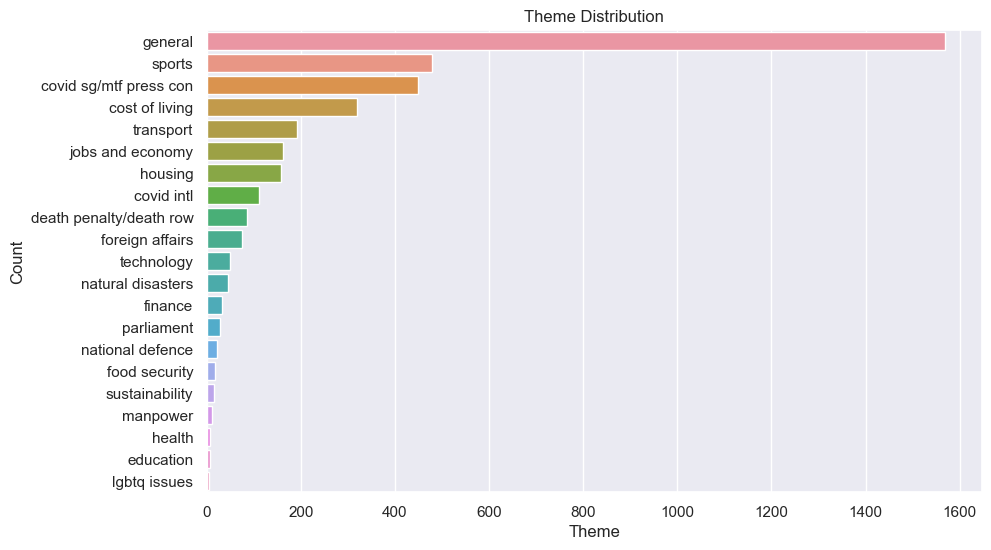

In [225]:
plot_themes(df_unique)

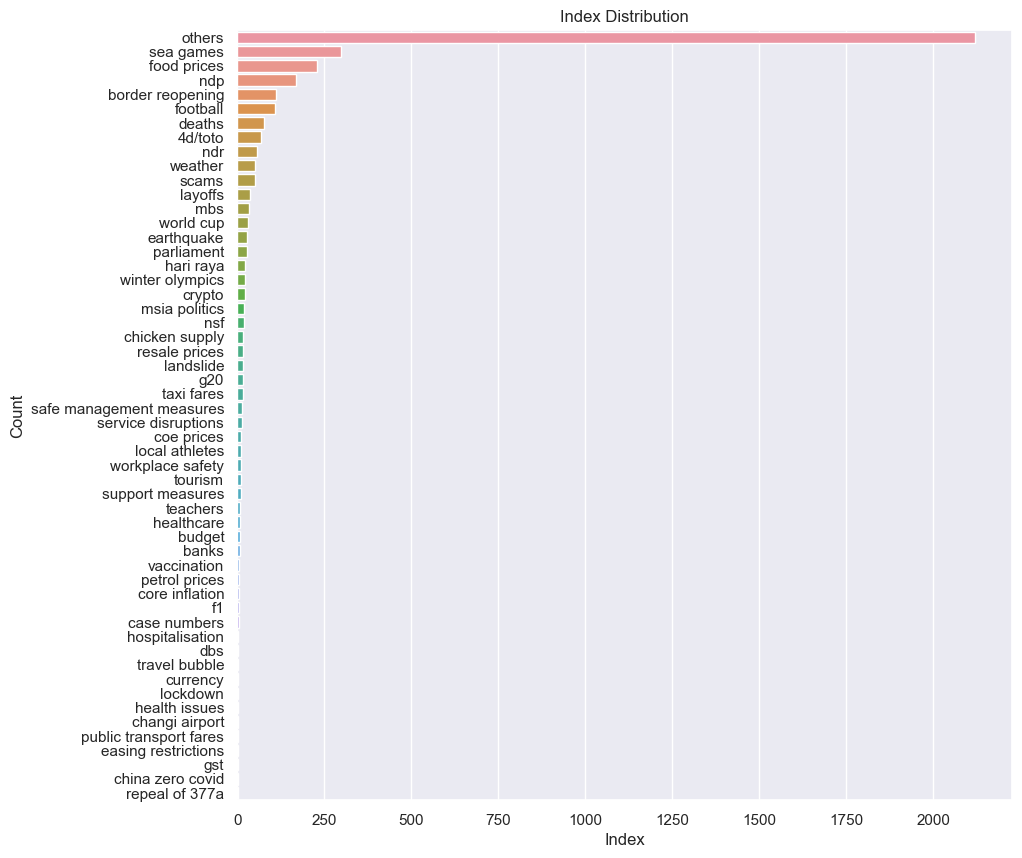

In [226]:
plot_index(df_unique)

Domain Analysis

In [184]:
def plot_domains(df_unique):
    plt.figure(figsize=(10, 6))
    sns.countplot(y='domain', data=df_unique, order=df_unique['domain'].value_counts().index)
    plt.title('Number of articles per domain')
    plt.xlabel('Number of articles')
    plt.ylabel('Domain')
    plt.show()

def plot_domain_group(df_unique):
    plt.figure(figsize=(10, 6))
    sns.countplot(y='domain_group', data=df_unique, order=df_unique['domain_group'].value_counts().index)
    plt.title('Number of articles per domain group')
    plt.xlabel('Number of articles')
    plt.ylabel('Domain Group')
    plt.show()

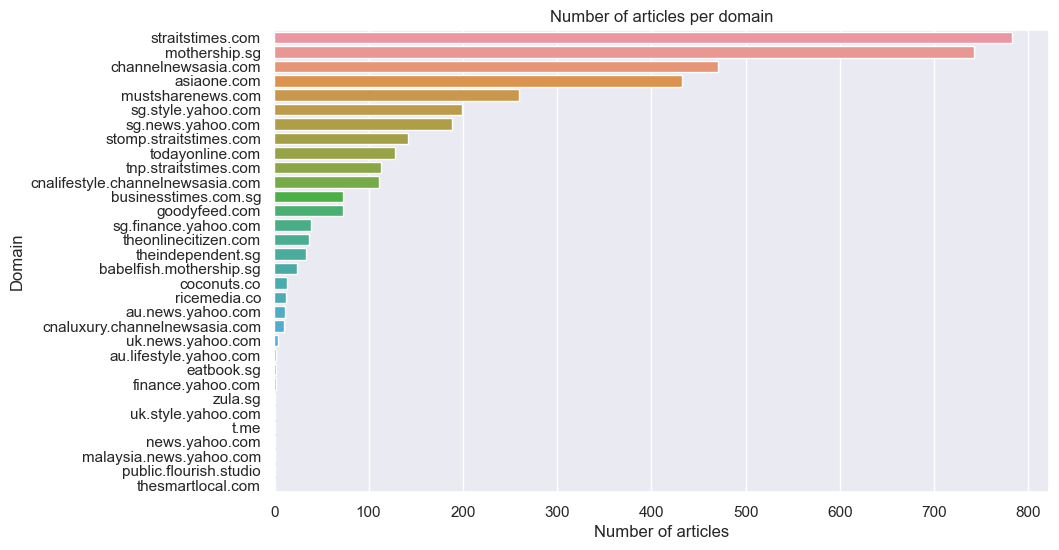

In [185]:
plot_domains(df_unfiltererd)

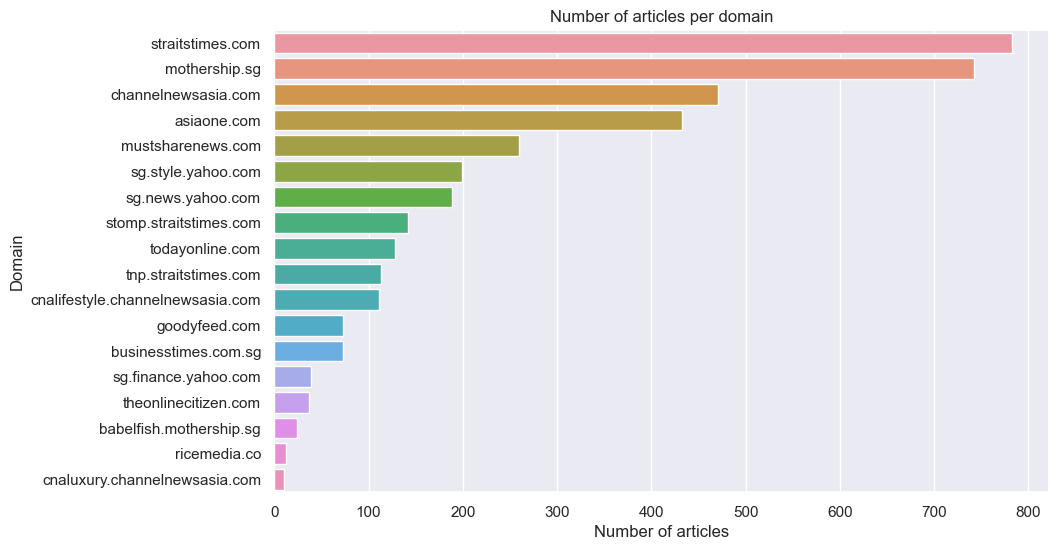

In [186]:
plot_domains(df_unique)

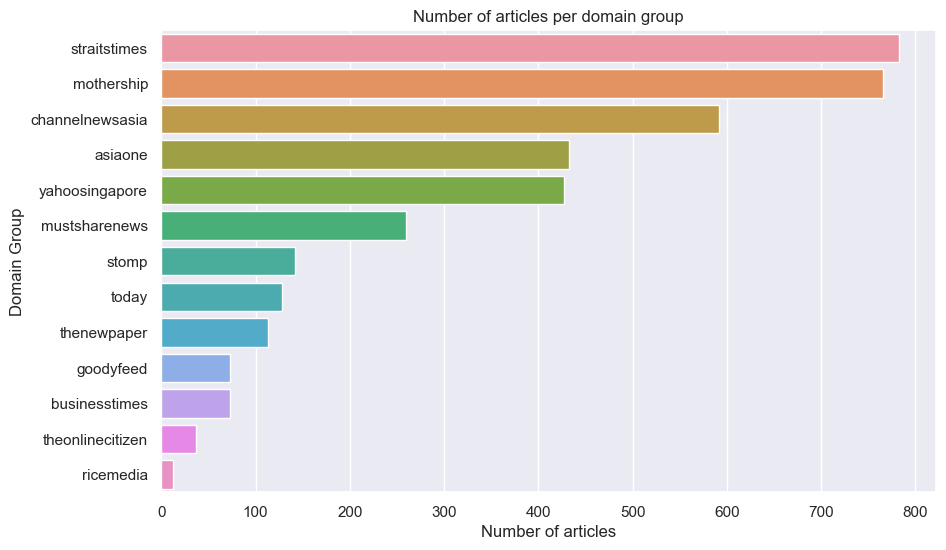

In [187]:
plot_domain_group(df_unique)

In [188]:
def plot_hisplot(df, col, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, bins=100, kde=True)
    plt.title(title)
    plt.show()

def display_sample_higher(df, col, threshold):
    return df[df[col] > threshold][['headline','article_index',col]].head(15).sort_values(by=col, ascending=False)

def display_sample_lower(df, col, threshold):
    return df[df[col] < threshold][['headline','article_index',col]].head(15).sort_values(by=col, ascending=True)


Hours since last article of the same index was published

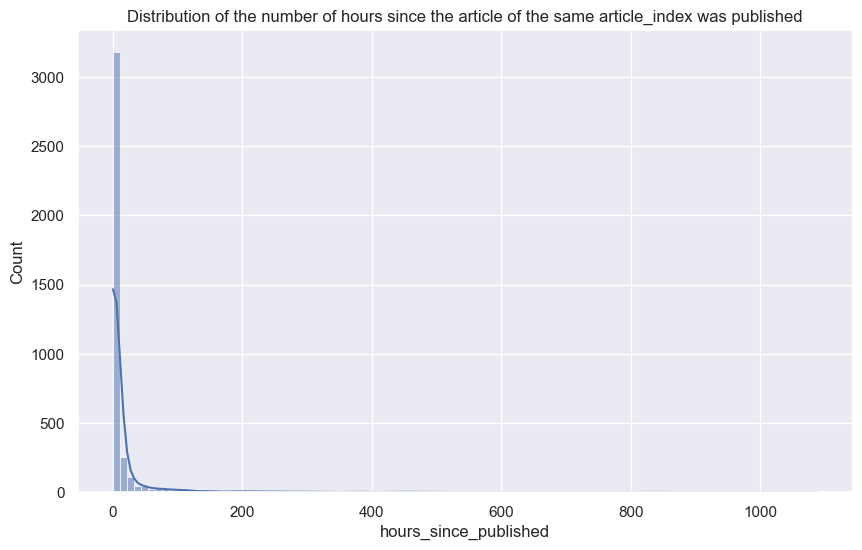

In [189]:
# Plot the distribution of the number of hours since the article of the same article_index was published

plot_hisplot(df_unique, 'hours_since_published', 'Distribution of the number of hours since the article of the same article_index was published')

In [190]:
display_sample_lower(df_unique, 'hours_since_published', 150)

,headline,article_index,hours_since_published
12,â€˜My husband checked for hidden cameras in our home toilet': Voyeur's victim still scarred,others,0.000278
8,"â€˜Sad and inhumane': Yishun resident finds nearly 30 pigeons, most of them dead, lying near HDB blocks",others,0.005833
2,â€˜We cannot stop covering Chinaâ€™ despite challenges faced: journalists at N3Con 2023,others,0.042222
0,â€˜Why is your client smiling?' Judge asks lawyer of voyeur who filmed women nearly 100 times,others,0.083611
9,"â€˜Sad and inhumane': Yishun resident finds nearly 30 pigeons, most of them dead, lying near HDB blocks",others,0.094167
11,â€˜My husband checked for hidden cameras in our home toilet': Voyeur's victim still scarred,others,0.113611
1,"â€˜We will always have your back': 4G team will look after workers in these dark times, says DPM Wong",others,0.131111
13,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has Everybody Wondering If Heâ€™s Okay,sea games,0.146111
6,â€˜The Godfather of AI' leaves Google and warns of danger ahead,others,0.202778
5,â€˜The Godfather of AIâ€™ leaves Google and warns of danger ahead,others,0.417778


In [191]:
display_sample_higher(df_unique, 'hours_since_published', 150)

,headline,article_index,hours_since_published
1172,S'pore-born comedian Jocelyn Chia called out by wife of MH370 steward after she jokes about missing flight - Babelfish,travel bubble,1088.068889
213,Whisky lifts spirits of inflation-hit investors,core inflation,696.586667
361,Trust expands product offerings in bid to become S'pore's 4th-largest bank,banks,478.498611
94,"Worker found dead at Tanjong Pagar building site, MOM and BCA order all work to stop",workplace safety,276.111667
44,"Zelenskyy has promised Ukraine will not use F-16 planes to go into Russia, says Biden",msia politics,274.665833
999,Same or not? Local TikTok user reviews UK's version of Singapore's beloved McSpicy,service disruptions,256.538056
752,South Korea experts say more study needed on Japan's nuclear water plan,g20,256.486944
730,"Staff chase after and catch woman, 26, who stole from 2 supermarkets in 1 day",scams,247.687500
496,The tech giants have an interest in AI regulation,layoffs,237.469444
517,The Singaporean Man Engineering F1 Racing Cars From His HDB Flat,f1,215.286111


Number of words in text

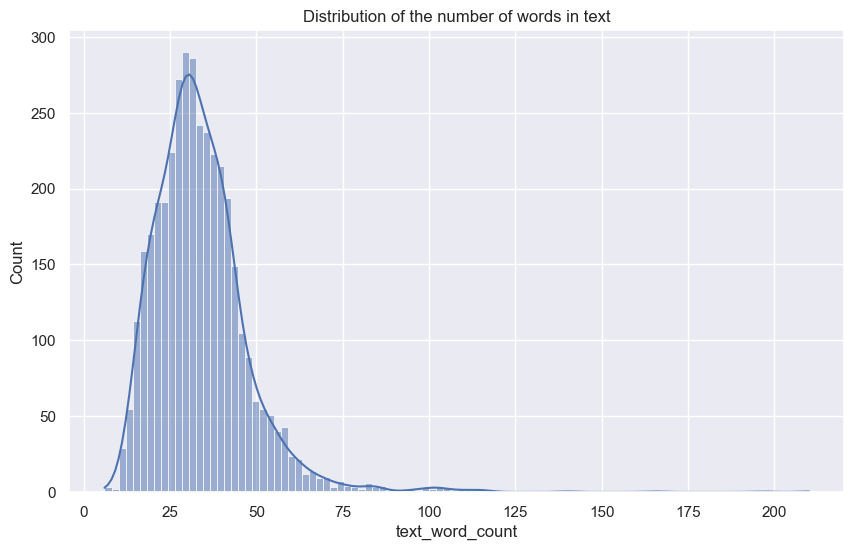

In [192]:
# Plot the distribution of the number of words in text

plot_hisplot(df_unique, 'text_word_count', 'Distribution of the number of words in text')

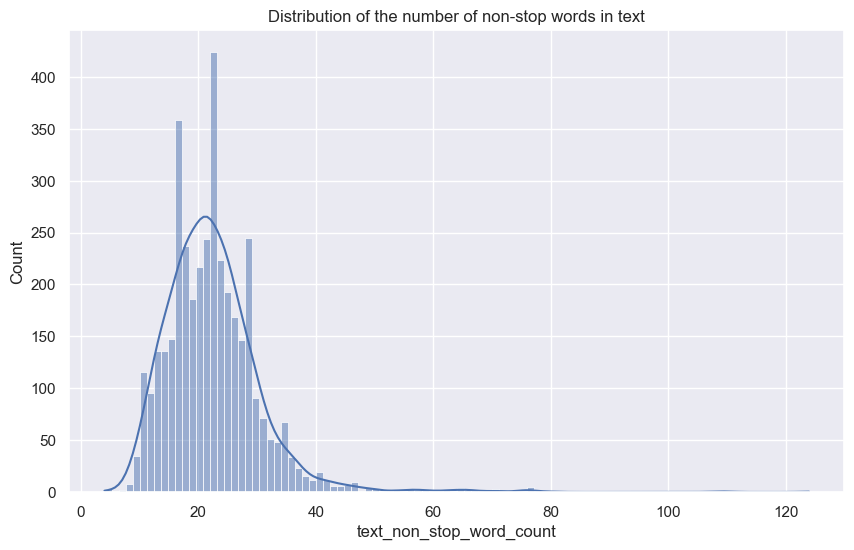

In [193]:
# Plot the distribution of the number of non-stop words in text

plot_hisplot(df_unique, 'text_non_stop_word_count', 'Distribution of the number of non-stop words in text')

Sentiment Analysis

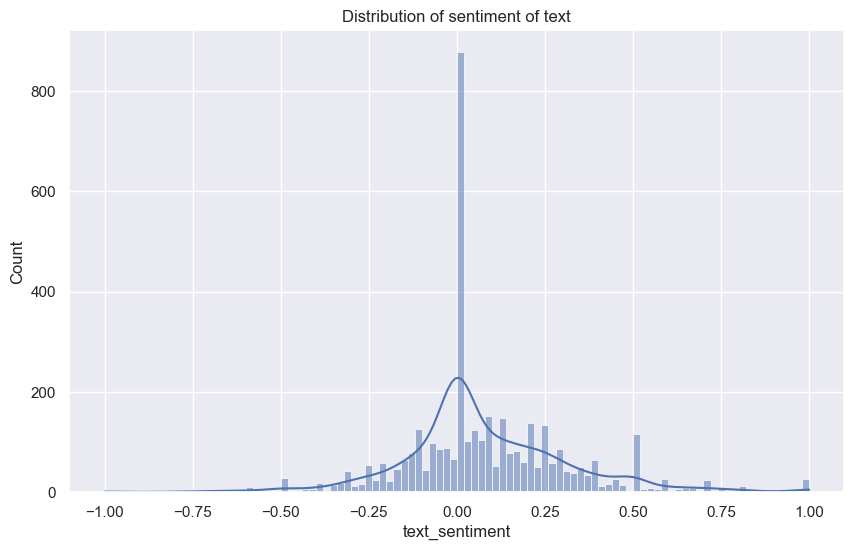

In [194]:
# Plot the distribution of sentiment of text

plot_hisplot(df_unique, 'text_sentiment', 'Distribution of sentiment of text')

In [195]:
display_sample_higher(df_unique, 'text_sentiment', 0.75)

,headline,article_index,text_sentiment
313,Understated pasar malam in Boon Lay has stalls with chuan chuan & stinky tofu till 12 Jun 2023,others,1.000
317,"Uncle Spotted Leisurely Doing Spin Class In Kallang, Looks Like He's Living His Best Life",others,1.000
636,"Sâ€™porean woman 1 of 10 in world to win US$10,000 from YouTuber MrBeast",4d/toto,1.000
649,Sâ€™pore Swimmer Quah Ting Wen Crowned Best Athlete Of Cambodia SEA Games 2023,sea games,1.000
825,Singapore's water polo teams receive 'heartwarming' reception on return from SEA Games,sea games,1.000
851,Singapore swimmer Quah Ting Wen named best athlete of 32nd SEA Games,sea games,1.000
992,Scientists discover a virgin birth in a crocodile,others,1.000
1041,SEA Games: â€˜She said yes!' - Proposal perfect ending to triathlete Bryce Chong's outing,sea games,1.000
1070,SEA Games 2023: Singapore win table tennis team gold with 1st all-local squad since 1973,sea games,1.000
119,Woman â€˜voted off flight by fellow passengersâ€™ after argument,others,0.800


In [196]:
display_sample_lower(df_unique, 'text_sentiment', -0.55)

,headline,article_index,text_sentiment
162,Woman details terrible punishment she suffered in childhood foster home,others,-1.000000
247,We try & rank 10 oat milk brands found in S'pore supermarkets,food prices,-0.800000
1000,Sambar deer fawn in S'pore dies after being stranded in canal for days,others,-0.750000
1697,Mercedes driver pleads guilty to drink driving after man dies in horrific multi-vehicle crash in Tampines,others,-0.720000
298,Vegan family requests neighbours to close their windows when cooking meat,chicken supply,-0.714286
206,Why Transformers star Anthony Ramos was shocked by durians,football,-0.700000
1448,Passenger shocked at Singapore Airlinesâ€™ â€˜patheticâ€™ breakfast on Melbourne flight,others,-0.700000
125,Woman threatens to sue Starbucks Malaysia after outlet writes her name as â€˜Babiâ€™,others,-0.666667
795,Singaporeâ€™s forgotten landmarks explained,others,-0.625000
888,Singapore Turf Club employees 'sad and disappointed' about racecourse closure,4d/toto,-0.625000


Subjectivity Analysis

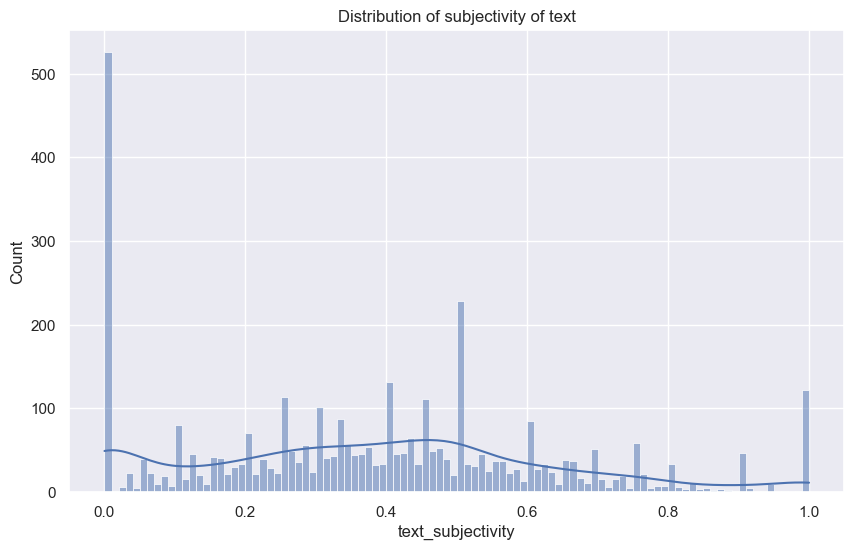

In [197]:
# Plot the distribution of subjectivity of text

plot_hisplot(df_unique, 'text_subjectivity', 'Distribution of subjectivity of text')

In [198]:
display_sample_higher(df_unique, 'text_subjectivity', 0.75)

,headline,article_index,text_subjectivity
99,Wong Lilin responds to criticism of her holding Cristiano Ronaldo's arm,football,1.000000
125,Woman threatens to sue Starbucks Malaysia after outlet writes her name as â€˜Babiâ€™,others,1.000000
162,Woman details terrible punishment she suffered in childhood foster home,others,1.000000
178,"Woman Stands & Waits Only For Sâ€™pore Bus To Drive Off, Asks If She Should've Flagged It",others,1.000000
191,Wife's battle with cancer inspires retiree to make $1m donation,ndp,1.000000
207,Why Tharman's candidacy is a boost for the elected presidency,ndr,1.000000
149,"Woman hangs underwear along corridor: 'Every morning, neighbours have to see her lingerie'",others,0.893750
203,"Why climb Everest? From snow to sand, adventurers are our ambassadors of possibility",landslide,0.875000
20,â€˜I now realise I cannot control everything in my lifeâ€™: A mum on how IVF changed her view of motherhood,others,0.850000
100,Wong Li Lin didn't defend her act of clinging on to Ronaldo's arm. An imposter did. - Babelfish,world cup,0.844444


In [199]:
display_sample_lower(df_unique, 'text_subjectivity', 0.25)

,headline,article_index,text_subjectivity
31,"library@esplanade to close on Jun 30, collections and programmes to move to National Library Building",others,0.000000
37,Zoo otter picks up visitor's dropped iPhone & bashes it against a rock,others,0.000000
44,"Zelenskyy has promised Ukraine will not use F-16 planes to go into Russia, says Biden",msia politics,0.000000
45,"Yusof Ishak Mosque worker jailed for smoking meth & stashing cannabis in ablution room, cubicle & locker",others,0.000000
34,askST: What happens next as Singapore gears up for the upcoming presidential election?,ndr,0.033333
50,Younger badminton players to carry Singaporeâ€™s hopes in SEA Games singles events,sea games,0.033333
65,You can now lock your chats on WhatsApp,safe management measures,0.100000
38,"Zoe Tay, Fann Wong head overseas for June school holidays",ndp,0.125000
30,"library@esplanade to close on June 30, collections and programmes to move to National Library Building",others,0.200000
59,YouTuber who staged plane crash faces up to 20 years jail: US officials,others,0.200000


Time of Posting Analysis

In [200]:
def agg_post_count_by_time(df_unique, agg_col, top_n=2):
    return (
        df_unique.groupby([agg_col, "domain_group"])
        .agg({"article_index": "count"})
        .reset_index()
        .sort_values(by=[agg_col, "article_index"], ascending=False)
        .groupby(agg_col)
        .head(top_n)
        .rename(columns={"article_index": "count"})
        .sort_values(by=[agg_col, 'count'], ascending=[True, False])
        .reset_index(drop=True)
    )

def plot_post_count_by_time(df_unique, agg_col, top_n=2):
    df = agg_post_count_by_time(df_unique, agg_col, top_n)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=agg_col, y="count", hue="domain_group")
    plt.title(f"Top {top_n} domains by {agg_col}")
    plt.show()

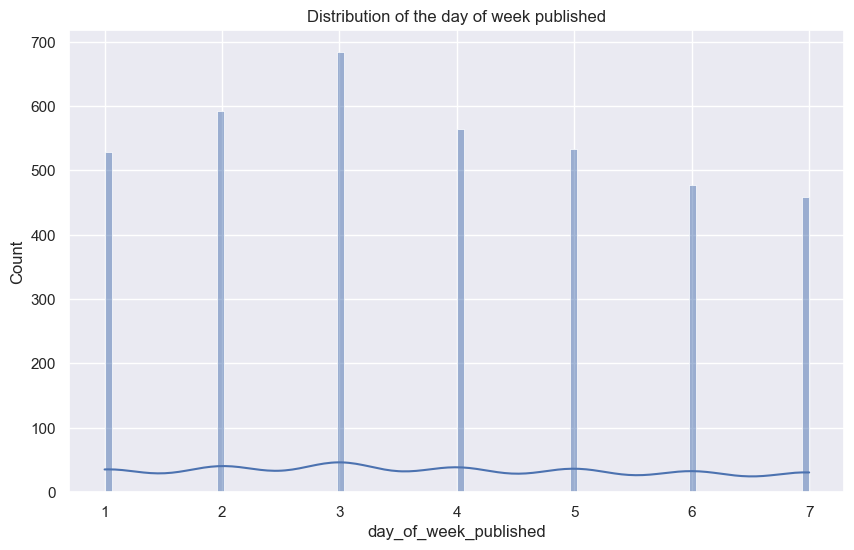

In [201]:
# Plot the distribution of the day of week published

plot_hisplot(df_unique, 'day_of_week_published', 'Distribution of the day of week published')

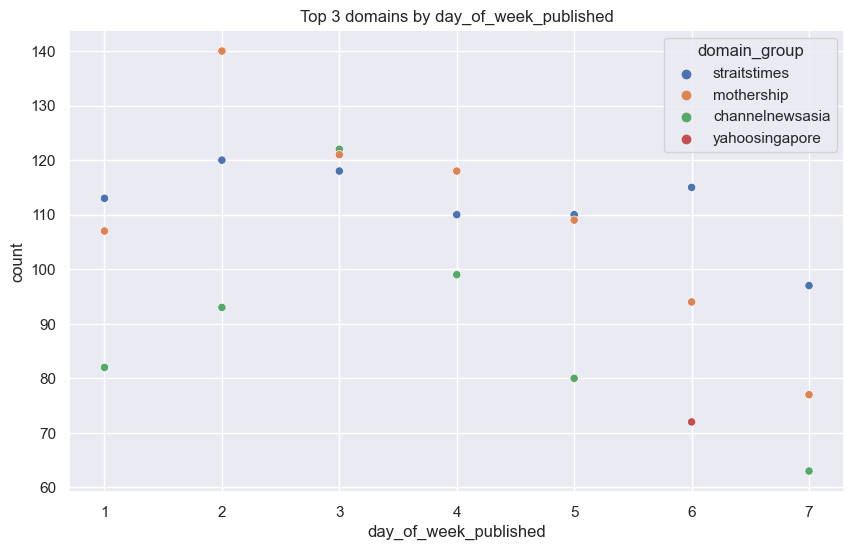

In [202]:
# Calculate on each day of the week, the domain_group with the highest mean number of articles published

plot_post_count_by_time(df_unique, "day_of_week_published", top_n=3)

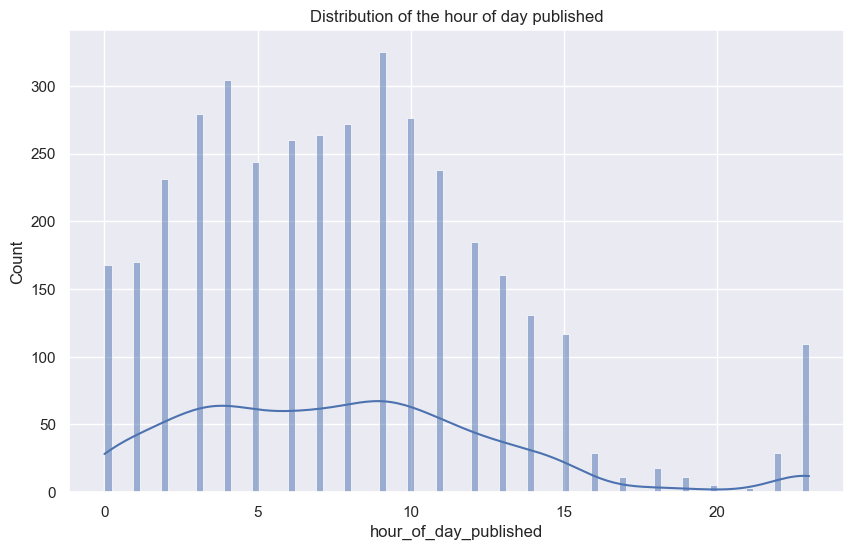

In [203]:
# Plot the distribution of the hour of day published

plot_hisplot(df_unique, 'hour_of_day_published', 'Distribution of the hour of day published')

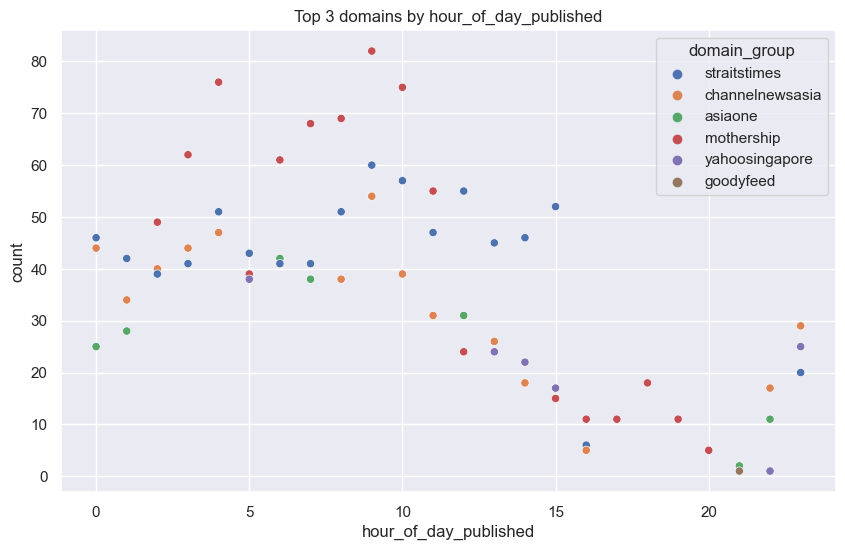

In [204]:
# Calculate on each hour of the day, the domain_group with the highest mean number of articles published

plot_post_count_by_time(df_unique, "hour_of_day_published", top_n=3)


### 4. Data Labelling

In [205]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer


In [206]:
GRD_THRESHOLD_UPPER = 1
GRD_THRESHOLD_LOWER = -1
VAL_ARR_THRESHOLD_UPPER = 1
VAL_ARR_THRESHOLD_LOWER = -1

In [228]:
def cal_article_mean_and_gradient(val_array):
    val_array = np.asarray(val_array)
    mean = np.mean(val_array)
    val_array = np.nan_to_num(val_array)
    model = LinearRegression()
    model.fit(np.arange(len(val_array)).reshape(-1, 1), val_array)
    gradient = model.coef_[0]
    return mean, gradient

def agg_mean_and_gradient(df):
    df_agg = df.groupby('link')['facebook_interactions'].agg(cal_article_mean_and_gradient).reset_index()
    return df_agg

def merge_labels(df_unique, df_agg):
    df_labelled = df_unique.merge(df_agg, on='link', how='left')
    df_labelled = df_labelled.rename(columns={'facebook_interactions_x': 'facebook_interactions', 'facebook_interactions_y': 'mean_and_gradient'})
    df_labelled['mean'] = df_labelled['mean_and_gradient'].apply(lambda x: x[0])
    df_labelled['gradient'] = df_labelled['mean_and_gradient'].apply(lambda x: x[1])
    df_labelled.drop(columns=['mean_and_gradient'], inplace=True)
    df_labelled['gradient'] = df_labelled['gradient'].apply(lambda x: 0 if x < 0 else x)
    return df_labelled

def normalise_mean_and_gradient(df_labelled):
    df_labelled['mean_s_scaled'] = StandardScaler().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_s_scaled'] = StandardScaler().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_r_scaled'] = RobustScaler().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_r_scaled'] = RobustScaler().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['mean']])
    df_labelled['gradient_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['gradient']])

    df_labelled['mean_log'] = np.log(df_labelled['mean'])
    df_labelled['gradient_log'] = np.log(df_labelled['gradient'])
    return df_labelled

def plot_gradient(df_labelled):
    fig, ax = plt.subplots(1, 7, figsize=(35, 5))
    sns.histplot(data=df_labelled, x='gradient', bins=100, kde=True, ax=ax[0])
    sns.histplot(data=df_labelled, x='gradient_s_scaled', bins=100, kde=True, ax=ax[1])
    sns.histplot(data=df_labelled, x='gradient_mm_scaled', bins=100, kde=True, ax=ax[2])
    sns.histplot(data=df_labelled, x='gradient_r_scaled', bins=100, kde=True, ax=ax[3])
    sns.histplot(data=df_labelled, x='gradient_pt_scaled', bins=100, kde=True, ax=ax[4])
    sns.histplot(data=df_labelled, x='gradient_qt_scaled', bins=100, kde=True, ax=ax[5])
    sns.histplot(data=df_labelled, x='gradient_log', bins=100, kde=True, ax=ax[6])
    plt.show()

def plot_mean(df_labelled):
    fig, ax = plt.subplots(1, 7, figsize=(35,5))
    sns.histplot(data=df_labelled, x='mean', bins=100, kde=True, ax=ax[0])
    sns.histplot(data=df_labelled, x='mean_s_scaled', bins=100, kde=True, ax=ax[1])
    sns.histplot(data=df_labelled, x='mean_mm_scaled', bins=100, kde=True, ax=ax[2])
    sns.histplot(data=df_labelled, x='mean_r_scaled', bins=100, kde=True, ax=ax[3])
    sns.histplot(data=df_labelled, x='mean_pt_scaled', bins=100, kde=True, ax=ax[4])
    sns.histplot(data=df_labelled, x='mean_qt_scaled', bins=100, kde=True, ax=ax[5])
    sns.histplot(data=df_labelled, x='mean_log', bins=100, kde=True, ax=ax[6])
    plt.show()

def get_label(row, colums):
    gradient_index = colums.index('gradient_pt_scaled')
    mean_index = colums.index('mean_pt_scaled')

    if row[gradient_index] > GRD_THRESHOLD_UPPER or row[mean_index] > VAL_ARR_THRESHOLD_UPPER:
        return "trending"
    
    elif row[gradient_index] < GRD_THRESHOLD_LOWER or row[mean_index] < VAL_ARR_THRESHOLD_LOWER:
        return "diminishing"
    
    else:
        return "neutral"
    
def map_labels_to_numertical(df_labelled):
    label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
    df_labelled['label'] = df_labelled['label'].map(label_mapper)
    return df_labelled
    
def plot_labels(df_labelled):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_labelled, x='label')
    plt.title('Distribution of Target Variable')
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.show()

def merge_labels_to_main(df_labelled, df):
    df_combined = df.merge(df_labelled[['link', 'label']], on='link', how='left')
    return df_combined

def get_article_activity_by_day(df_labelled, df):
    df_combined = df.merge(df_labelled[['link', 'label']], on='link', how='left')
    unique_articles = df_combined['link'].unique()
    activity_df = pd.DataFrame()

    for article in unique_articles:
        df_slice = df_combined[df_combined['link'] == article].reset_index(drop=True)
        df_slice = df_slice.reset_index().rename(columns={'index': 'day'})
        df_slice['day'] = df_slice['day'] + 1
        activity_df = activity_df.append(df_slice)

    return activity_df
    
def plot_activities(activity_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=activity_df, x='day', y='facebook_interactions', hue='label')
    plt.title('Facebook Interactions over Days')
    plt.xlabel('Day')
    plt.ylabel('Facebook Interactions')
    plt.show()



In [208]:
df_agg = agg_mean_and_gradient(df)
df_labelled = merge_labels(df_unique, df_agg)
df_labelled = normalise_mean_and_gradient(df_labelled)
df_labelled['label'] = df_labelled.apply(lambda x: get_label(x, list(df_labelled.columns)), axis=1)

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


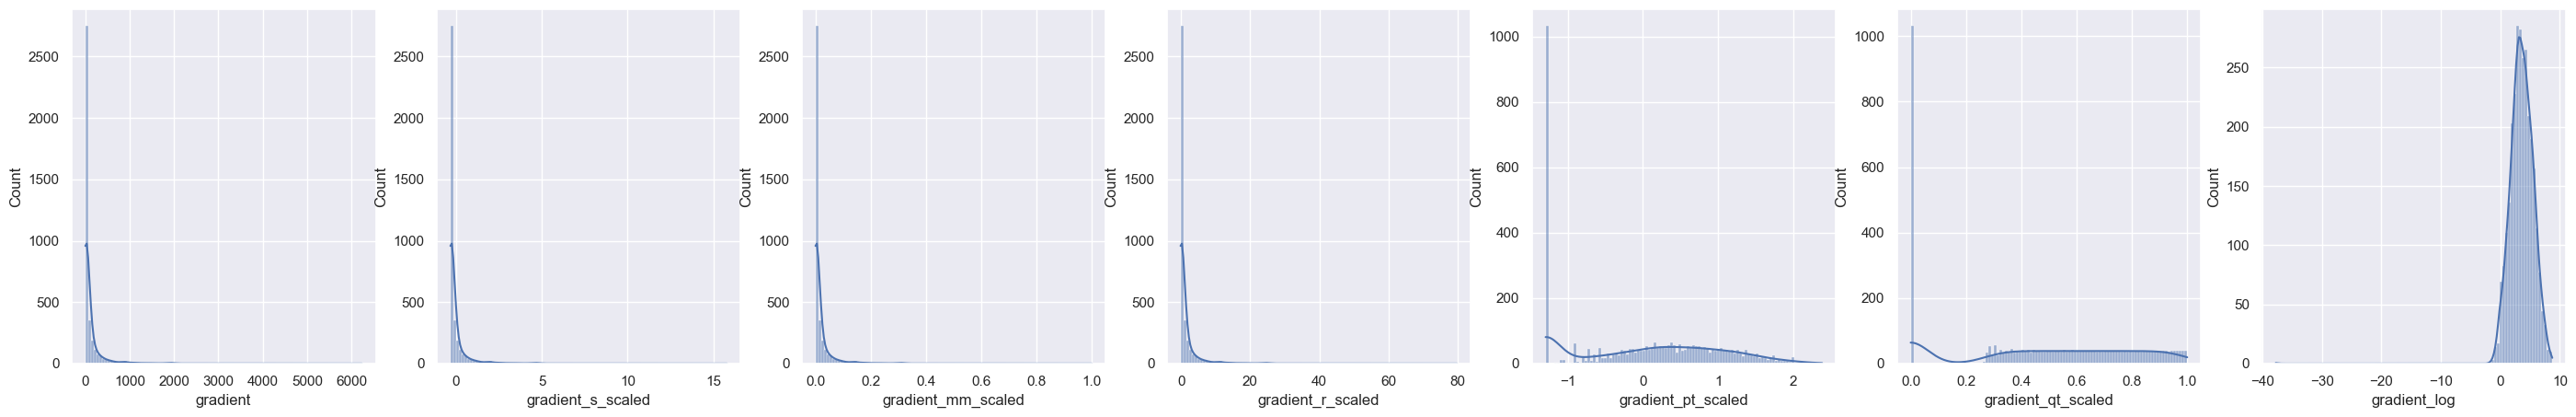

In [209]:
plot_gradient(df_labelled)

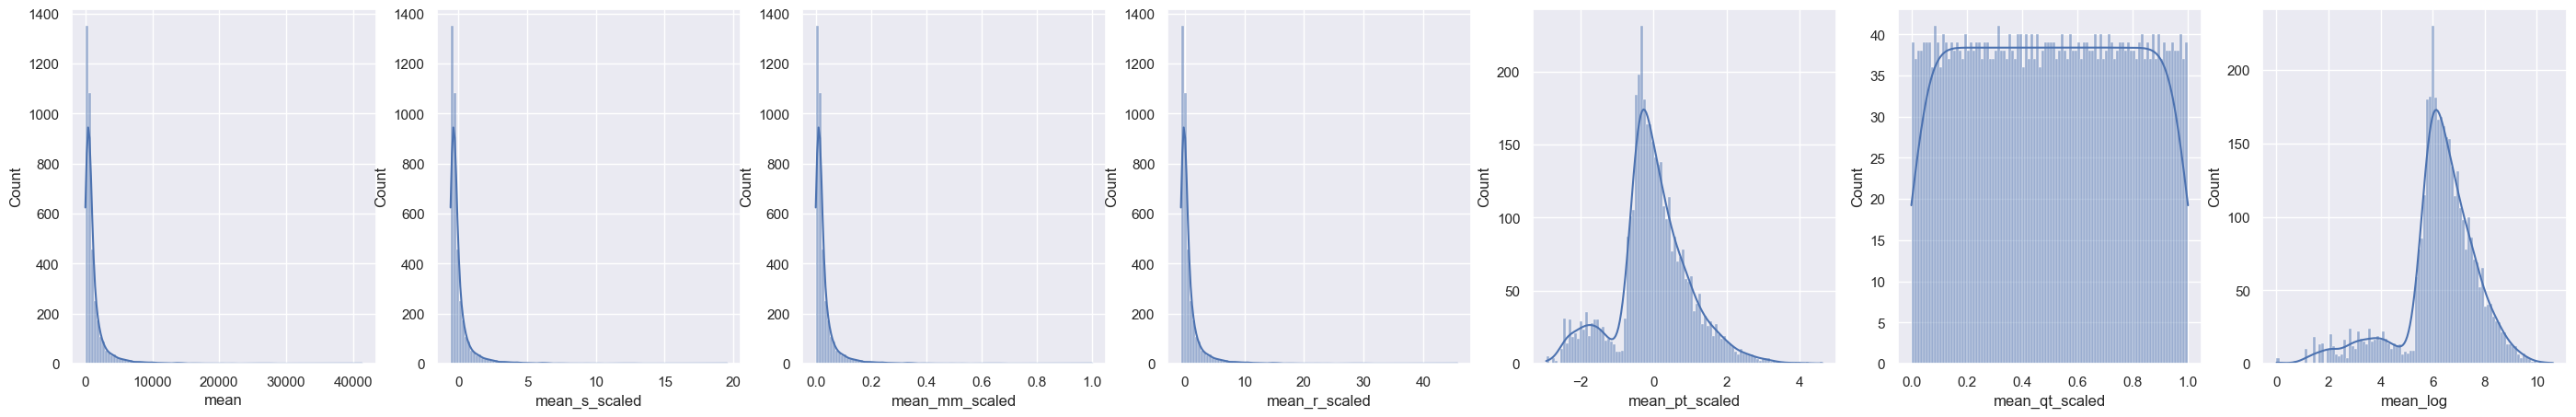

In [210]:
plot_mean(df_labelled)

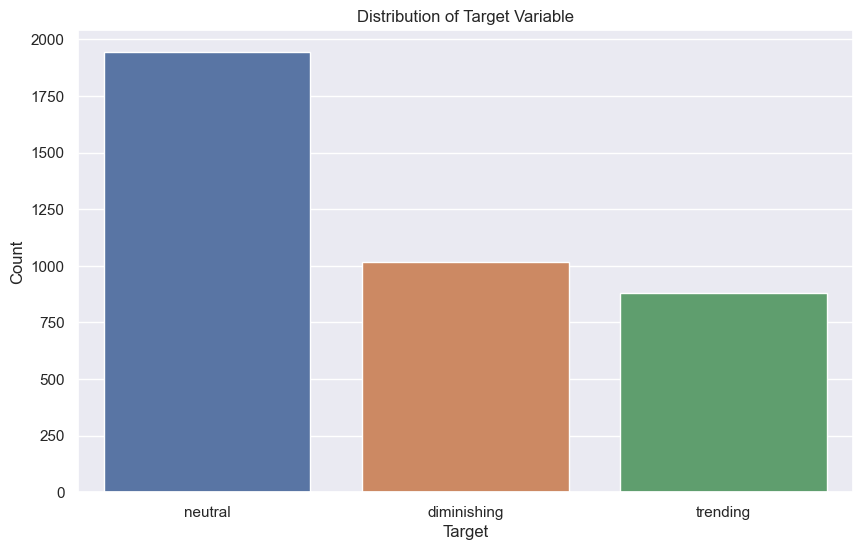

In [211]:
plot_labels(df_labelled)

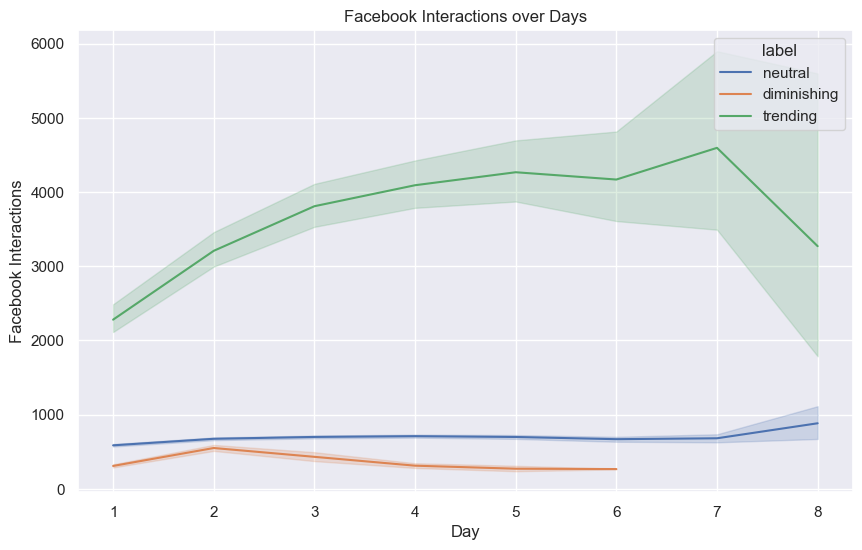

In [212]:
activity_df = get_article_activity_by_day(df_labelled, df)
plot_activities(activity_df)

In [229]:
df_labelled = map_labels_to_numertical(df_labelled)

Index Traction by Aggregation (Majority Weighted Voting)

In [244]:
def get_index_aggregated_labels(df_labelled, col_name):
    df_agg = df_labelled.copy()
    df_agg[f'{col_name}_d'] = df_agg[col_name].apply(lambda x: x)
    df_agg = pd.get_dummies(df_agg, columns=[f'{col_name}_d'])
    dummy_label_cols = [col for col in df_agg.columns if f'{col_name}_d' in col]

    # Assuming equal weighted voting
    df_agg["vote_weights"] = 1

    for col in dummy_label_cols:
        df_agg[col] = df_agg[col] * df_agg['vote_weights']

    df_agg = df_agg.groupby('article_index')[dummy_label_cols].sum().idxmax(axis=1).reset_index().rename(columns={0: 'label'})
    df_agg['label'] = df_agg[col_name].apply(lambda x: int(x[-1]))
    return df_agg.sort_values(by='label', ascending=False).reset_index(drop=True)


In [243]:
get_index_aggregated_labels(df_labelled, 'label')

,article_index,label
27,local athletes,2
21,hari raya,2
24,hospitalisation,1
26,layoffs,1
28,lockdown,1
29,mbs,1
30,msia politics,1
31,ndp,1
33,nsf,1
34,others,1
